In [27]:
token = "7460c822a2aa48cb85af7ccd4236f6f0dd63a54141fbd8b75e877c5776d2844bbbf5a7d854289894a99380443e7a5232954a858267d10d4bb29a4554ae4d71b9"
from qiskit_ibm_runtime import QiskitRuntimeService
 
# If you did not previously save your credentials, use the following line instead:
# service = QiskitRuntimeService(channel="ibm_quantum", token="<MY_IBM_QUANTUM_TOKEN>")
# service = QiskitRuntimeService()
# Save an IBM Quantum account and set it as your default account.
QiskitRuntimeService.save_account(channel="ibm_quantum", token=token, set_as_default=True,overwrite=True)
 
# Load saved credentials
service = QiskitRuntimeService()
service.backends()



[<IBMBackend('ibm_brisbane')>,
 <IBMBackend('ibm_kyiv')>,
 <IBMBackend('ibm_sherbrooke')>]

In [28]:
backend = service.least_busy(operational=True, simulator=False, min_num_qubits=8)
backend

<IBMBackend('ibm_sherbrooke')>

In [29]:
import pennylane as qml
import numpy as np
import random
import matplotlib.pyplot as plt
import csv
import pandas as pd
import argparse
import os
import math
import datetime
import time
from frechetdist import frdist

import torchvision.transforms as transforms
from torchvision.utils import save_image

from torch.utils.data import DataLoader
from torchvision import datasets
from torch.autograd import Variable

import torch.utils.data as data
import torch.nn as nn
import torch.nn.functional as F
import torch

from solver import Solver
from data_loader import get_loader
from torch.backends import cudnn
from utils import *
from models import Generator, Discriminator
from data.sparse_molecular_dataset import SparseMolecularDataset
from rdkit import Chem

In [30]:
def str2bool(v):
    return v.lower() in ('true')

qubits = 8
# Set up your ibmq credentials first from https://quantum-computing.ibm.com/
demo_on_ibmq = True

# if demo_on_ibmq:
#     dev = qml.device('qiskit.remote', wires=qubits, backend=backend)
# else:
dev = qml.device('default.qubit', wires=qubits)

@qml.qnode(dev, interface='torch')
def gen_circuit(w):
    # random noise as generator input
    z1 = random.uniform(-1, 1)
    z2 = random.uniform(-1, 1)
    layers = 1    
    
    # construct generator circuit for both atom vector and node matrix
    for i in range(qubits):
        qml.RY(np.arcsin(z1), wires=i)
        qml.RZ(np.arcsin(z2), wires=i)
        
    for l in range(layers):
        for i in range(qubits):
            qml.RY(w[i], wires=i)
        for i in range(qubits-1):
            qml.CNOT(wires=[i, i+1])
            qml.RZ(w[i+qubits], wires=i+1)
            qml.CNOT(wires=[i, i+1])
    return [qml.expval(qml.PauliZ(i)) for i in range(qubits)]

In [31]:
parser = argparse.ArgumentParser()

# Quantum circuit configuration
parser.add_argument('--quantum', type=bool, default=True, help='choose to use quantum gan with hybrid generator')
parser.add_argument('--patches', type=int, default=1, help='number of quantum circuit patches')
parser.add_argument('--layer', type=int, default=1, help='number of repeated variational quantum layer')
parser.add_argument('--qubits', type=int, default=8, help='number of qubits and dimension of domain labels')

# Model configuration.
parser.add_argument('--z_dim', type=int, default=8, help='dimension of domain labels')
parser.add_argument('--g_conv_dim', default=[128], help='number of conv filters in the first layer of G')
parser.add_argument('--d_conv_dim', type=int, default=[[128, 64], 128, [128, 64]], help='number of conv filters in the first layer of D')
parser.add_argument('--g_repeat_num', type=int, default=6, help='number of residual blocks in G')
parser.add_argument('--d_repeat_num', type=int, default=6, help='number of strided conv layers in D')
parser.add_argument('--lambda_cls', type=float, default=1, help='weight for domain classification loss')
parser.add_argument('--lambda_rec', type=float, default=10, help='weight for reconstruction loss')
parser.add_argument('--lambda_gp', type=float, default=10, help='weight for gradient penalty')
parser.add_argument('--post_method', type=str, default='softmax', choices=['softmax', 'soft_gumbel', 'hard_gumbel'])

# Training configuration.
parser.add_argument('--batch_size', type=int, default=16, help='mini-batch size')
parser.add_argument('--num_iters', type=int, default=5000, help='number of total iterations for training D')
parser.add_argument('--num_iters_decay', type=int, default=2500, help='number of iterations for decaying lr')
parser.add_argument('--g_lr', type=float, default=0.0001, help='learning rate for G')
parser.add_argument('--d_lr', type=float, default=0.0001, help='learning rate for D')
parser.add_argument('--dropout', type=float, default=0., help='dropout rate')
parser.add_argument('--n_critic', type=int, default=5, help='number of D updates per each G update')
parser.add_argument('--beta1', type=float, default=0.5, help='beta1 for Adam optimizer')
parser.add_argument('--beta2', type=float, default=0.999, help='beta2 for Adam optimizer')
parser.add_argument('--resume_iters', type=int, default=None, help='resume training from this step')

# Test configuration.
parser.add_argument('--test_iters', type=int, default=5000, help='test model from this step')

# Miscellaneous.
parser.add_argument('--num_workers', type=int, default=1)
parser.add_argument('--mode', type=str, default='train', choices=['train', 'test'])
parser.add_argument('--use_tensorboard', type=str2bool, default=False)

# Directories.
parser.add_argument('--mol_data_dir', type=str, default='data/gdb9_9nodes.sparsedataset')
parser.add_argument('--log_dir', type=str, default='qgan-hg/logs')
parser.add_argument('--model_save_dir', type=str, default='qgan-hg/models')
parser.add_argument('--sample_dir', type=str, default='qgan-hg/samples')
parser.add_argument('--result_dir', type=str, default='qgan-hg/results')

# Step size.
parser.add_argument('--log_step', type=int, default=10)
parser.add_argument('--sample_step', type=int, default=1000)
parser.add_argument('--model_save_step', type=int, default=1000)
parser.add_argument('--lr_update_step', type=int, default=500)

config = parser.parse_known_args()[0]
print(config)

Namespace(quantum=True, patches=1, layer=1, qubits=8, z_dim=8, g_conv_dim=[128], d_conv_dim=[[128, 64], 128, [128, 64]], g_repeat_num=6, d_repeat_num=6, lambda_cls=1, lambda_rec=10, lambda_gp=10, post_method='softmax', batch_size=16, num_iters=5000, num_iters_decay=2500, g_lr=0.0001, d_lr=0.0001, dropout=0.0, n_critic=5, beta1=0.5, beta2=0.999, resume_iters=None, test_iters=5000, num_workers=1, mode='train', use_tensorboard=False, mol_data_dir='data/gdb9_9nodes.sparsedataset', log_dir='qgan-hg/logs', model_save_dir='qgan-hg/models', sample_dir='qgan-hg/samples', result_dir='qgan-hg/results', log_step=10, sample_step=1000, model_save_step=1000, lr_update_step=500)


In [32]:
self = Solver(config)

Generator(
  (layers): Sequential(
    (0): Linear(in_features=8, out_features=128, bias=True)
    (1): Tanh()
    (2): Dropout(p=0.0, inplace=True)
  )
  (edges_layer): Linear(in_features=128, out_features=405, bias=True)
  (nodes_layer): Linear(in_features=128, out_features=45, bias=True)
  (dropoout): Dropout(p=0.0, inplace=False)
)
G
The number of parameters: 59202
Discriminator(
  (gcn_layer): GraphConvolution(
    (linear1): Linear(in_features=5, out_features=128, bias=True)
    (linear2): Linear(in_features=128, out_features=64, bias=True)
    (dropout): Dropout(p=0.0, inplace=False)
  )
  (agg_layer): GraphAggregation(
    (sigmoid_linear): Sequential(
      (0): Linear(in_features=69, out_features=128, bias=True)
      (1): Sigmoid()
    )
    (tanh_linear): Sequential(
      (0): Linear(in_features=69, out_features=128, bias=True)
      (1): Tanh()
    )
    (dropout): Dropout(p=0.0, inplace=False)
  )
  (linear_layer): Sequential(
    (0): Linear(in_features=128, out_feature

In [33]:
# Inference of generated molecules
start_iters = 0
self.resume_iters = 4000

if self.resume_iters:
    start_iters = self.resume_iters
    self.restore_model(self.resume_iters)
    gen_weights = torch.tensor([-0.11443097,-0.23893048,-0.26079974,0.52572775,0.04154618,0.7797117,\
                                -0.22719051,0.04173521,-0.7405998,0.040963333,0.13625668,0.5491951,0.41576374,-0.059020802,0.7136884], requires_grad=True)
ibm_sample_list = []
for i in range(self.batch_size):
    # Running time depends on the queue of IBM melbourne machine
    if demo_on_ibmq:
        print("IBM Q running job {}/{}".format(i+1, self.batch_size), end="\r")
    ibm_sample_list.append(torch.tensor(gen_circuit(gen_weights)).to(self.device).float())

Loading the trained models from step 4000...


FileNotFoundError: [Errno 2] No such file or directory: 'qgan-hg/models/4000-G.ckpt'

In [ ]:
# Start inference.
print('Start inference...')
start_time = time.time()

mols, _, _, a, x, _, _, _, _ = self.data.next_train_batch(self.batch_size)

# =================================================================================== #
#                             1. Preprocess input data                                #
# =================================================================================== #

a = torch.from_numpy(a).to(self.device).long()            # Adjacency.
x = torch.from_numpy(x).to(self.device).long()            # Nodes.
a_tensor = self.label2onehot(a, self.b_dim)
x_tensor = self.label2onehot(x, self.m_dim)
z = torch.stack(tuple(ibm_sample_list)).to(self.device).float()

# Z-to-target
edges_logits, nodes_logits = self.G(z)
# Postprocess with Gumbel softmax
(edges_hat, nodes_hat) = self.postprocess((edges_logits, nodes_logits), self.post_method)
logits_fake, features_fake = self.D(edges_hat, None, nodes_hat)
g_loss_fake = - torch.mean(logits_fake)

# Real Reward
rewardR = torch.from_numpy(self.reward(mols)).to(self.device)
# Fake Reward
(edges_hard, nodes_hard) = self.postprocess((edges_logits, nodes_logits), 'hard_gumbel')
edges_hard, nodes_hard = torch.max(edges_hard, -1)[1], torch.max(nodes_hard, -1)[1]
mols = [self.data.matrices2mol(n_.data.cpu().numpy(), e_.data.cpu().numpy(), strict=True)
        for e_, n_ in zip(edges_hard, nodes_hard)]
rewardF = torch.from_numpy(self.reward(mols)).to(self.device)

# Value loss
value_logit_real,_ = self.V(a_tensor, None, x_tensor, torch.sigmoid)
value_logit_fake,_ = self.V(edges_hat, None, nodes_hat, torch.sigmoid)
g_loss_value = torch.mean((value_logit_real - rewardR) ** 2 + (
                           value_logit_fake - rewardF) ** 2)

R=[list(a[i].reshape(-1))  for i in range(self.batch_size)]
F=[list(edges_hard[i].reshape(-1))  for i in range(self.batch_size)]
fd_bond_only = frdist(R, F)

R=[list(x[i]) + list(a[i].reshape(-1))  for i in range(self.batch_size)]
F=[list(nodes_hard[i]) + list(edges_hard[i].reshape(-1))  for i in range(self.batch_size)]
fd_bond_atom = frdist(R, F)

loss = {}
loss['G/loss_fake'] = g_loss_fake.item()
loss['G/loss_value'] = g_loss_value.item()
loss['FD/fd_bond_only'] = fd_bond_only
loss['FD/fd_bond_atom'] = fd_bond_atom

Start inference...


[12:53:27] non-ring atom 0 marked aromatic
[12:53:27] non-ring atom 5 marked aromatic
[12:53:27] Explicit valence for atom # 8 C, 7, is greater than permitted
[12:53:27] non-ring atom 3 marked aromatic
[12:53:27] Explicit valence for atom # 1 O, 3, is greater than permitted
[12:53:27] Explicit valence for atom # 5 C, 6, is greater than permitted


In [ ]:
# Print out training information.
et = time.time() - start_time
et = str(datetime.timedelta(seconds=et))[:-7]
log = "Elapsed [{}], Iteration [{}/{}]".format(et, start_iters, self.num_iters)

# Log update
m0, m1 = all_scores(mols, self.data, norm=True)     # 'mols' is output of Fake Reward
m0 = {k: np.array(v)[np.nonzero(v)].mean() for k, v in m0.items()}
m0.update(m1)
loss.update(m0)
for tag, value in loss.items():
    log += ", {}: {:.4f}".format(tag, value)
print(log)

Elapsed [0:00:02], Iteration [2580/5000], G/loss_fake: -0.8787, G/loss_value: 0.0319, FD/fd_bond_only: 12.9615, FD/fd_bond_atom: 13.4536, NP score: 0.7550, QED score: 0.4811, logP score: 0.4933, SA score: nan, diversity score: 1.0000, drugcandidate score: 0.3561, valid score: 62.5000, unique score: 80.0000, novel score: 100.0000


/var/folders/sv/2cnfp66152jb0hq74_5q4cvm0000gn/T/ipykernel_37198/1095380643.py:8: RuntimeWarning: Mean of empty slice.
  m0 = {k: np.array(v)[np.nonzero(v)].mean() for k, v in m0.items()}
/opt/anaconda3/envs/qgai/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


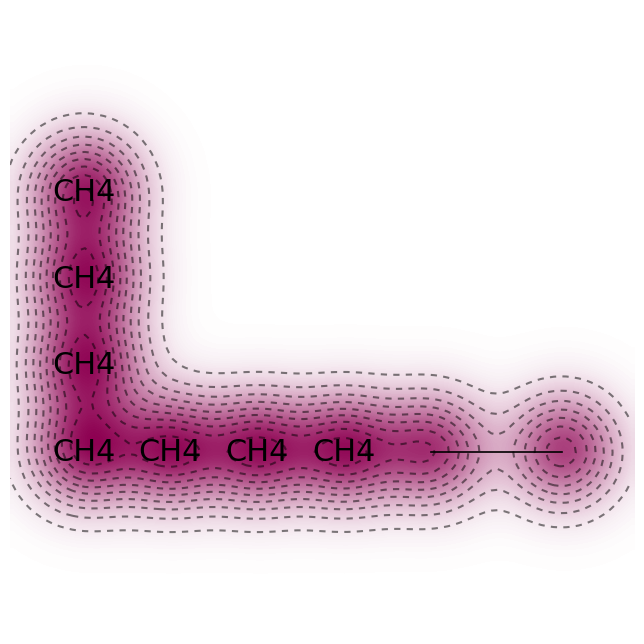

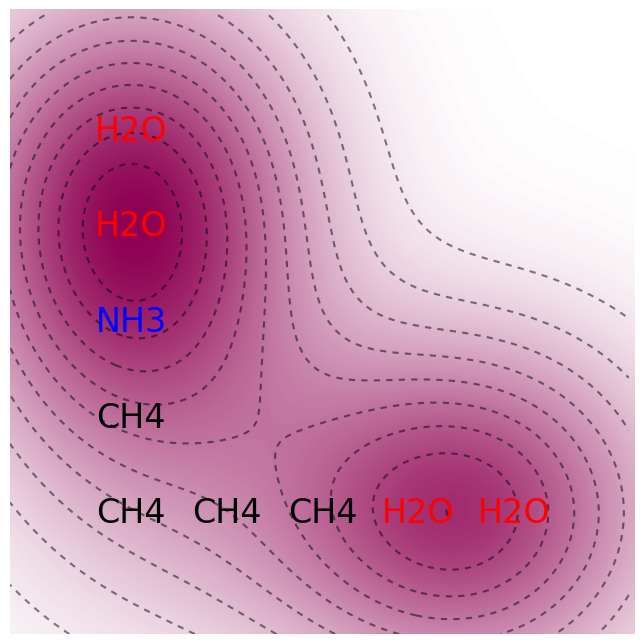

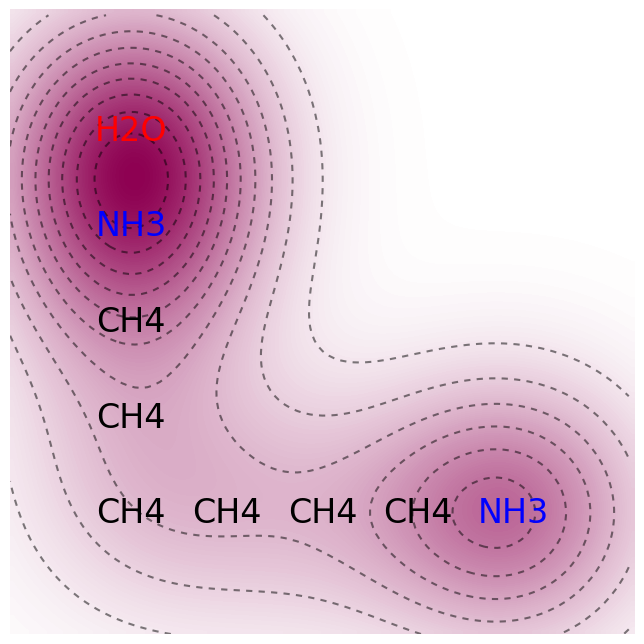

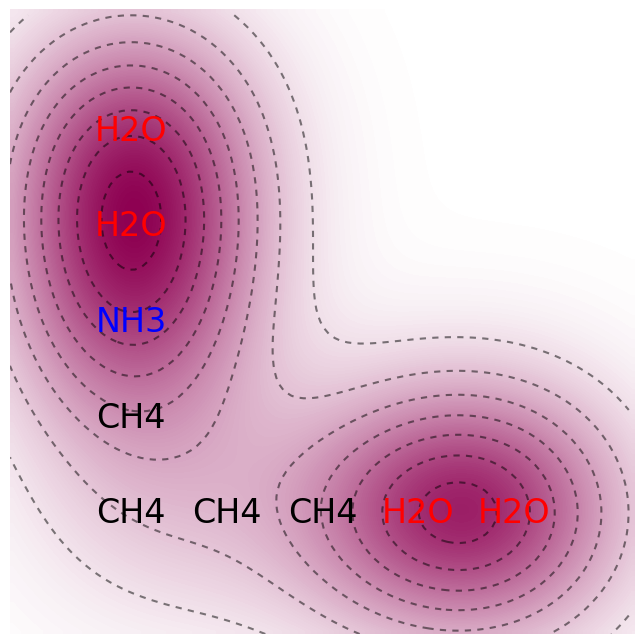

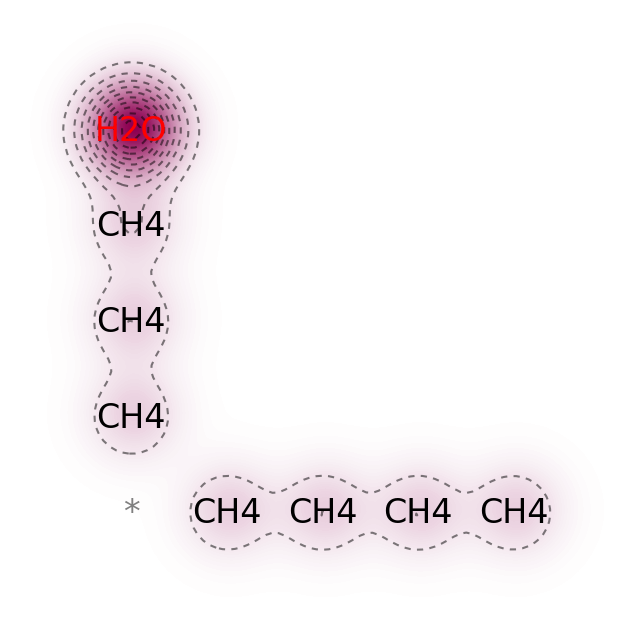

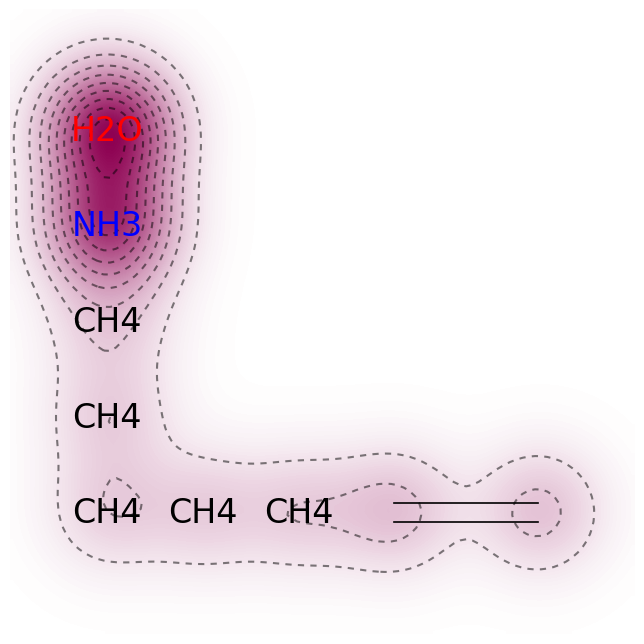

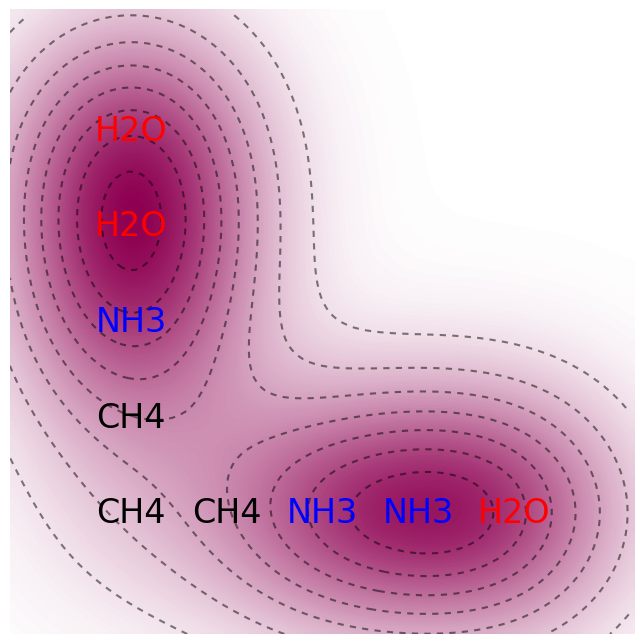

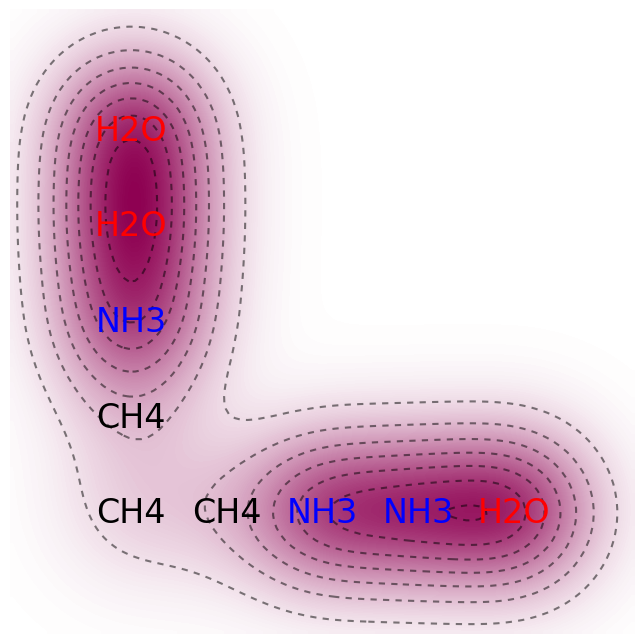

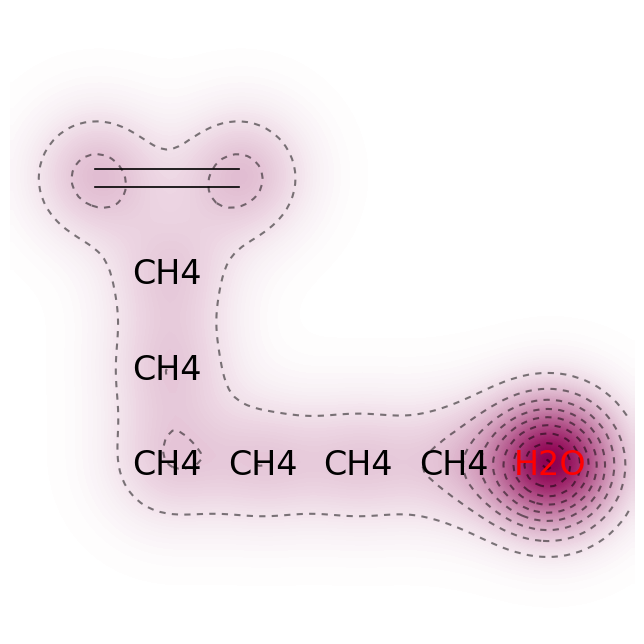

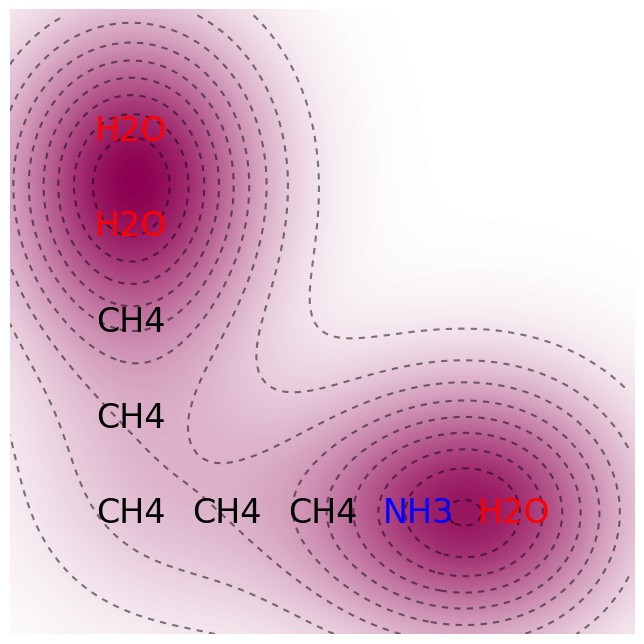

In [ ]:
# Keep only valid moleculues evaluated by RDKit
valid_mols = [i for i in mols if i != None]

from rdkit.Chem.Draw import SimilarityMaps
import matplotlib

for mol in valid_mols:
    AllChem.ComputeGasteigerCharges(mol)
    contribs = [mol.GetAtomWithIdx(i).GetDoubleProp('_GasteigerCharge') for i in range(mol.GetNumAtoms())]
    fig = SimilarityMaps.GetSimilarityMapFromWeights(mol, contribs, colorMap=None,  contourLines=10)